In [1]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [36]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1_10-30.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

/tmp/ipykernel_110838/2243626001.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1_10-30.csv")


In [37]:
weather_forecast_data_2.columns

Index(['location', 'ts', 'cloud', 'temp', 'temp_max', 'temp_min', 'humidity',
       'ground_press', 'wind_speed', 'wind_dir', 'rain', 'snow'],
      dtype='object')

In [38]:
weather_forecast_data_2_jeju = weather_forecast_data_2[weather_forecast_data_2['location'] == 'Jeju']

In [39]:
# 'hour' 열 추가
weather_forecast_data_2_jeju['hour'] = pd.to_datetime(weather_forecast_data_2_jeju['ts'], unit='s').dt.hour

# 'date' 열 추가
weather_forecast_data_2_jeju['date'] = pd.to_datetime(weather_forecast_data_2_jeju['ts'], unit='s').dt.date

/tmp/ipykernel_110838/2367410811.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_forecast_data_2_jeju['hour'] = pd.to_datetime(weather_forecast_data_2_jeju['ts'], unit='s').dt.hour
/tmp/ipykernel_110838/2367410811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_forecast_data_2_jeju['hour'] = pd.to_datetime(weather_forecast_data_2_jeju['ts'], unit='s').dt.hour
/tmp/ipykernel_110838/2367410811.py:5: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing stri

In [40]:
weather_forecast_data_2_jeju

,location,ts,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,hour,date
22673,Jeju,1709218851,93.0,7.18,7.18,7.18,76.0,1023.0,8.23,341.0,0.11,0.0,15,2024-02-29
22674,Jeju,1709220660,75.0,7.96,7.96,7.96,66.0,1022.0,3.09,340.0,0.0,0.0,15,2024-02-29
22675,Jeju,1709222452,95.0,6.87,6.87,6.87,77.0,1023.0,8.98,340.0,0.0,0.0,16,2024-02-29
22676,Jeju,1709224270,75.0,7.96,7.96,7.96,66.0,1022.0,4.63,340.0,0.0,0.0,16,2024-02-29
22677,Jeju,1709226056,96.0,6.15,6.15,6.15,71.0,1024.0,9.52,342.0,0.77,0.0,17,2024-02-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34007,Jeju,1729600283,75.0,21.96,21.96,21.96,83.0,1016.0,6.17,270.0,0.53,0.0,12,2024-10-22
34008,Jeju,1729602067,75.0,19.96,19.96,19.96,94.0,1016.0,10.8,300.0,0.53,0.0,13,2024-10-22
34009,Jeju,1729603843,75.0,19.96,19.96,19.96,88.0,1016.0,10.8,290.0,0.48,0.0,13,2024-10-22
34010,Jeju,1729605674,100.0,20.29,20.29,20.29,92.0,1016.0,9.07,299.0,0.48,0.0,14,2024-10-22


In [41]:
weather_forecast_data_2_jeju = weather_forecast_data_2_jeju.drop_duplicates(subset=['date', 'hour'], keep='first')

In [42]:
weather_forecast_data_2_jeju

,location,ts,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,hour,date
22673,Jeju,1709218851,93.0,7.18,7.18,7.18,76.0,1023.0,8.23,341.0,0.11,0.0,15,2024-02-29
22675,Jeju,1709222452,95.0,6.87,6.87,6.87,77.0,1023.0,8.98,340.0,0.0,0.0,16,2024-02-29
22677,Jeju,1709226056,96.0,6.15,6.15,6.15,71.0,1024.0,9.52,342.0,0.77,0.0,17,2024-02-29
22679,Jeju,1709229638,97.0,5.79,5.79,5.79,67.0,1024.0,9.4,340.0,0.0,0.0,18,2024-02-29
22681,Jeju,1709233254,53.0,5.19,5.19,5.19,69.0,1024.0,9.94,340.0,0.0,0.0,19,2024-02-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34002,Jeju,1729591263,97.0,21.83,21.83,21.83,86.0,1015.0,5.65,280.0,0.0,0.0,10,2024-10-22
34004,Jeju,1729594848,97.0,21.77,21.77,21.77,87.0,1015.0,6.01,271.0,0.0,0.0,11,2024-10-22
34006,Jeju,1729598477,99.0,21.67,21.67,21.67,91.0,1015.0,7.09,282.0,0.18,0.0,12,2024-10-22
34008,Jeju,1729602067,75.0,19.96,19.96,19.96,94.0,1016.0,10.8,300.0,0.53,0.0,13,2024-10-22


In [43]:
# 'hour' 열 추가
jeju_power_market_day_ahead['hour'] = pd.to_datetime(jeju_power_market_day_ahead['ts'], unit='s').dt.hour

# 'date' 열 추가
jeju_power_market_day_ahead['date'] = pd.to_datetime(jeju_power_market_day_ahead['ts'], unit='s').dt.date

In [44]:
jeju_power_market_day_ahead

,ts,하루전가격(원/kWh),hour,date
0,1709218800,107.39,15,2024-02-29
1,1709222400,107.39,16,2024-02-29
2,1709226000,95.30,17,2024-02-29
3,1709229600,87.89,18,2024-02-29
4,1709233200,0.00,19,2024-02-29
...,...,...,...,...
5660,1729594800,156.68,11,2024-10-22
5661,1729598400,152.54,12,2024-10-22
5662,1729602000,106.92,13,2024-10-22
5663,1729605600,150.97,14,2024-10-22


In [45]:
df = pd.merge(weather_forecast_data_2_jeju, jeju_power_market_day_ahead, on=['hour', 'date'], how='left')

In [46]:
df

,location,ts_x,cloud,temp,temp_max,temp_min,humidity,ground_press,wind_speed,wind_dir,rain,snow,hour,date,ts_y,하루전가격(원/kWh)
0,Jeju,1709218851,93.0,7.18,7.18,7.18,76.0,1023.0,8.23,341.0,0.11,0.0,15,2024-02-29,1709218800,107.39
1,Jeju,1709222452,95.0,6.87,6.87,6.87,77.0,1023.0,8.98,340.0,0.0,0.0,16,2024-02-29,1709222400,107.39
2,Jeju,1709226056,96.0,6.15,6.15,6.15,71.0,1024.0,9.52,342.0,0.77,0.0,17,2024-02-29,1709226000,95.30
3,Jeju,1709229638,97.0,5.79,5.79,5.79,67.0,1024.0,9.4,340.0,0.0,0.0,18,2024-02-29,1709229600,87.89
4,Jeju,1709233254,53.0,5.19,5.19,5.19,69.0,1024.0,9.94,340.0,0.0,0.0,19,2024-02-29,1709233200,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,Jeju,1729591263,97.0,21.83,21.83,21.83,86.0,1015.0,5.65,280.0,0.0,0.0,10,2024-10-22,1729591200,156.68
5660,Jeju,1729594848,97.0,21.77,21.77,21.77,87.0,1015.0,6.01,271.0,0.0,0.0,11,2024-10-22,1729594800,156.68
5661,Jeju,1729598477,99.0,21.67,21.67,21.67,91.0,1015.0,7.09,282.0,0.18,0.0,12,2024-10-22,1729598400,152.54
5662,Jeju,1729602067,75.0,19.96,19.96,19.96,94.0,1016.0,10.8,300.0,0.53,0.0,13,2024-10-22,1729602000,106.92


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      5664 non-null   object 
 1   ts_x          5664 non-null   object 
 2   cloud         5664 non-null   object 
 3   temp          5664 non-null   object 
 4   temp_max      5664 non-null   object 
 5   temp_min      5664 non-null   object 
 6   humidity      5664 non-null   object 
 7   ground_press  5664 non-null   object 
 8   wind_speed    5664 non-null   object 
 9   wind_dir      5664 non-null   object 
 10  rain          5664 non-null   object 
 11  snow          5664 non-null   object 
 12  hour          5664 non-null   int32  
 13  date          5664 non-null   object 
 14  ts_y          5664 non-null   int64  
 15  하루전가격(원/kWh)  5664 non-null   float64
dtypes: float64(1), int32(1), int64(1), object(13)
memory usage: 686.0+ KB


In [48]:
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      5664 non-null   object 
 1   ts_x          5664 non-null   object 
 2   cloud         5664 non-null   object 
 3   temp          5664 non-null   object 
 4   temp_max      5664 non-null   object 
 5   temp_min      5664 non-null   object 
 6   humidity      5664 non-null   object 
 7   ground_press  5664 non-null   object 
 8   wind_speed    5664 non-null   object 
 9   wind_dir      5664 non-null   object 
 10  rain          5664 non-null   object 
 11  snow          5664 non-null   object 
 12  hour          5664 non-null   int32  
 13  date          5664 non-null   object 
 14  ts_y          5664 non-null   int64  
 15  하루전가격(원/kWh)  5664 non-null   float64
 16  sin_hour      5664 non-null   float64
 17  cos_hour      5664 non-null   float64
dtypes: float64(3), int32(1), int

In [50]:
df = df.drop(['location', 'ts_x', 'ts_y', 'hour', 'date'], axis=1)
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [51]:
df = df.astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cloud         5664 non-null   float64
 1   temp          5664 non-null   float64
 2   temp_max      5664 non-null   float64
 3   temp_min      5664 non-null   float64
 4   humidity      5664 non-null   float64
 5   ground_press  5664 non-null   float64
 6   wind_speed    5664 non-null   float64
 7   wind_dir      5664 non-null   float64
 8   rain          5664 non-null   float64
 9   snow          5664 non-null   float64
 10  sin_hour      5664 non-null   float64
 11  cos_hour      5664 non-null   float64
 12  하루전가격(원/kWh)  5664 non-null   float64
dtypes: float64(13)
memory usage: 575.4 KB


In [52]:
y = df['하루전가격(원/kWh)']
x = df.drop('하루전가격(원/kWh)', axis=1)

In [53]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = int(len(y) * 0.05))
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

train data shape
x:(5381, 12), y:(5381,)


/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current fon

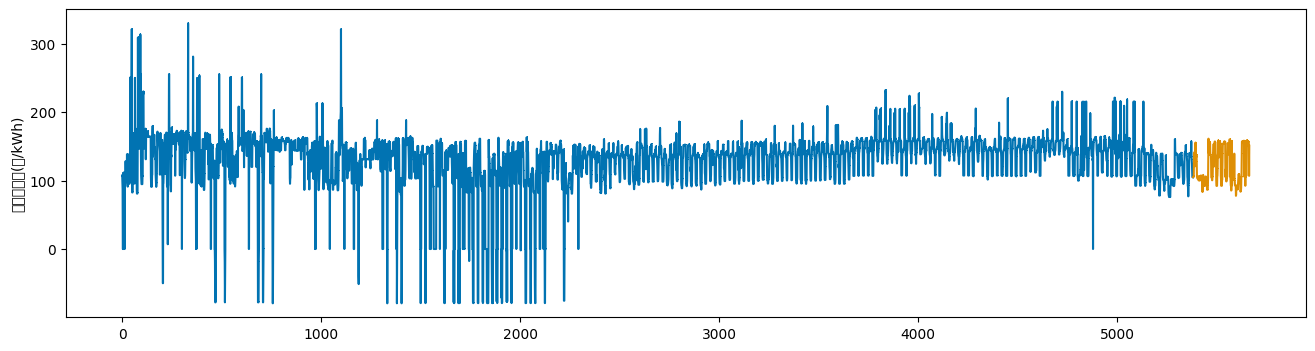

In [54]:
from sktime.utils.plotting import plot_series

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [55]:
from xgboost import XGBRegressor

# XGBRegressor 모델 생성 (GPU 사용)
xgb_reg = XGBRegressor(
    n_estimators=3000, 
    learning_rate=0.01,      # 학습률
    min_child_weight=0.5,      # 최소 가중치
    max_depth=7,             # 최대 깊이
    colsample_bytree=0.8,    # 컬럼 샘플링 비율
    subsample=0.8,           # 데이터 샘플링 비율
    tree_method='hist',      # 'hist' 사용
    device='cuda',           # GPU 사용 설정
    seed=0,
    early_stopping_rounds = 500
)

xgb_reg.fit(
    x_train, y_train, 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)

/home/jinjinjara1022/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:36:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


SMAPE : 7.285607011143972


/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  func(*args, **kwargs)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  func(*args, **kwargs)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  func(*args, **kwargs)
/home/jinjinjara1022/.local/lib/python3.10/site-packages/IPython/core/

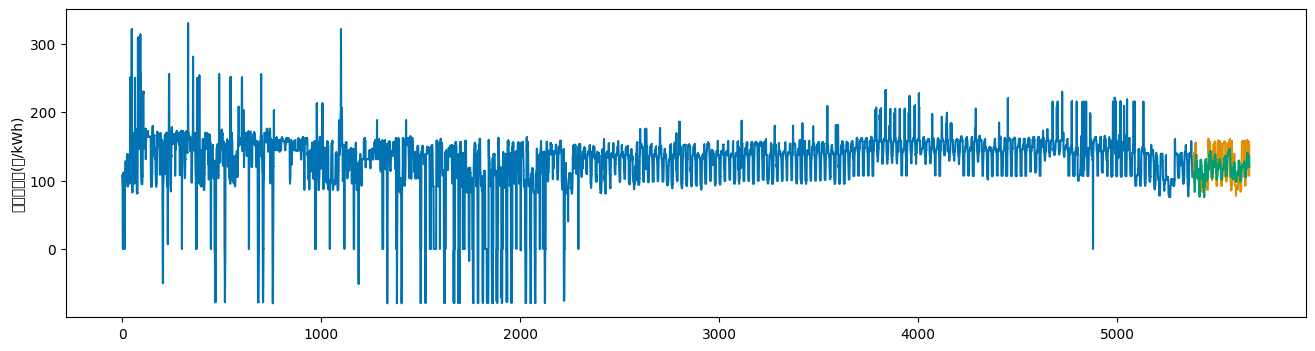

In [57]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='하루전가격(원/kWh)'>)

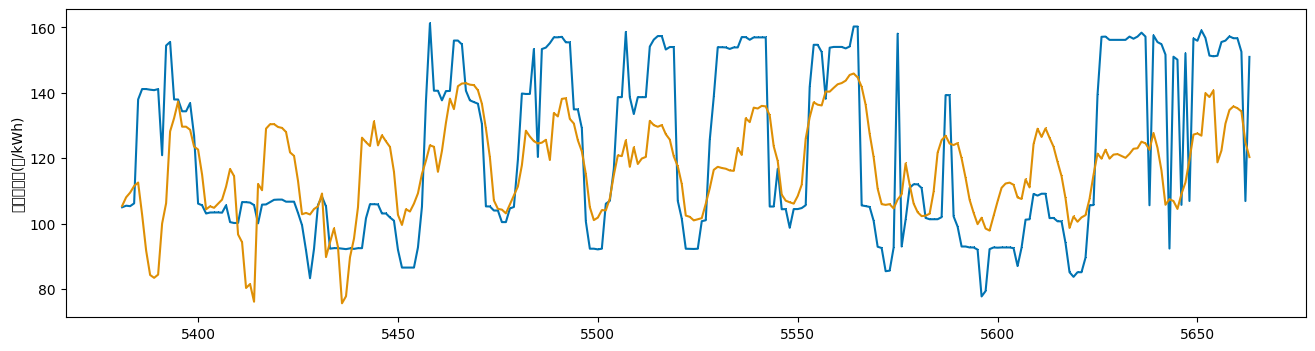

In [58]:
plot_series( y_valid, pd.Series(pred), markers=[ ',', ','])